**Practice**

In [230]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score,precision_recall_curve,precision_score,recall_score,confusion_matrix,classification_report,auc,roc_auc_score,roc_curve
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Create data

In [231]:
X,y = make_classification(n_samples=1000,n_classes=2,n_features=10)

Split data

In [232]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

Scale data for pca

In [233]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

Apply PCA to visualize the data

In [234]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)

In [235]:
X_train_pca.shape
y_train.shape

(800,)

Scatter plot the data to visualize

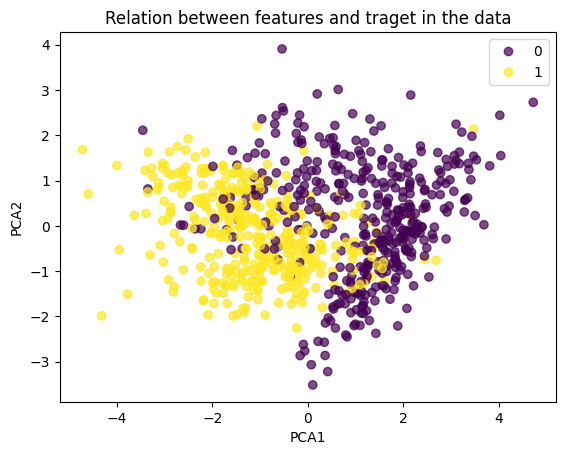

In [236]:
scatter = plt.scatter(X_train_pca[:,0],X_train_pca[:,1],c=y_train,cmap='viridis',alpha=0.7)
legend = plt.legend(scatter.legend_elements()[0], scatter.legend_elements()[1], loc='upper right')
plt.title("Relation between features and traget in the data")
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show()

Decision Tree

In [237]:
def train_model(model):
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    # print(f"Accuracy of {type(model).__name__} is {accuracy_score(y_test,y_pred)}")
    return y_pred

In [238]:
models = [DecisionTreeClassifier(),RandomForestClassifier(),SVC()]
for model in models:
    train_model(model)

In [239]:
def evaluate_models(name,y_pred):
    print(f'''Evaluation scores for {name}\n
Accuracy is {accuracy_score(y_pred,y_test)}\n
precision is {precision_score(y_pred,y_test)}\n
recall is {recall_score(y_pred,y_test)}\n
confussion matrix: \n{confusion_matrix(y_test,y_pred)}\n
classification report: \n{classification_report(y_test,y_pred)}\n
''')

In [240]:
for model in models:
    y_pred = train_model(model)
    evaluate_models(type(model).__name__,y_pred)

Evaluation scores for DecisionTreeClassifier

Accuracy is 0.91

precision is 0.9405940594059405

recall is 0.8878504672897196

confussion matrix: 
[[87 12]
 [ 6 95]]

classification report: 
              precision    recall  f1-score   support

           0       0.94      0.88      0.91        99
           1       0.89      0.94      0.91       101

    accuracy                           0.91       200
   macro avg       0.91      0.91      0.91       200
weighted avg       0.91      0.91      0.91       200



Evaluation scores for RandomForestClassifier

Accuracy is 0.925

precision is 0.9603960396039604

recall is 0.8981481481481481

confussion matrix: 
[[88 11]
 [ 4 97]]

classification report: 
              precision    recall  f1-score   support

           0       0.96      0.89      0.92        99
           1       0.90      0.96      0.93       101

    accuracy                           0.93       200
   macro avg       0.93      0.92      0.92       200
weighted avg    